<a href="https://colab.research.google.com/github/Abhi23run/CSE8803_DLT_Project/blob/main/b_finetune_t5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/dlt_results

/content/drive/MyDrive/dlt_results


In [4]:
!python a_create_data_t5.py

6251 883 1147
Net Errors: 198
Net Errors: 35
Net Errors: 39
spiece.model: 100% 792k/792k [00:00<00:00, 14.6MB/s]
tokenizer.json: 100% 1.39M/1.39M [00:00<00:00, 24.2MB/s]
config.json: 100% 1.21k/1.21k [00:00<00:00, 5.52MB/s]
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the defaul

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import transformers
from torch.optim import Adam
from tqdm import tqdm

In [6]:
import os

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast

In [8]:
from utils import FinQA_Dataset

### Declarations

In [9]:
BATCH_SIZE = 8
NUM_EPOCHS = 40
TESTING = False

In [10]:
finqa_train = torch.load('finqa_train.pth')
finqa_valid = torch.load('finqa_valid.pth')

In [11]:
# TOKENIZER = T5Tokenizer.from_pretrained("t5-base")
MODEL = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict=True)
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0005)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Read Data and create DataLoader

In [12]:
# os.environ["TRANSFORMERS_OFFLINE"] = "1"

In [13]:
if TESTING:
    train_loader = DataLoader(Subset(finqa_train, range(100)), batch_size=BATCH_SIZE)
    val_loader = DataLoader(Subset(finqa_valid, range(10)), batch_size=BATCH_SIZE)
else:
    train_loader = DataLoader(finqa_train, batch_size=BATCH_SIZE)
    val_loader = DataLoader(finqa_valid, batch_size=BATCH_SIZE)

### Train Loop

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [15]:
# import torch.quantization
# quantization_config = torch.quantization.get_default_qconfig('fbgemm')

# Quantize the model
# MODEL = torch.quantization.quantize_dynamic(MODEL, {torch.nn.Linear}, dtype=torch.qint8)

In [16]:
MODEL.to(DEVICE);

In [17]:
torch.cuda.empty_cache();

In [18]:
# import logging
import warnings
warnings.filterwarnings("ignore")

# logging.basicConfig(filename='training.log', filemode='w', level=logging.INFO, format='%(message)s')

In [19]:
import logging
from datetime import datetime
logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"/content/drive/MyDrive/dlt_results/mylog_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [20]:
train_loss = 0
val_loss = 0
b = 0
v = 0
train_hist = []
val_hist = []
num_batches = len(train_loader)
print_every = num_batches // 10

for epoch in range(NUM_EPOCHS):
    MODEL.train()
    for batch in train_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)
        outputs = MODEL(input_ids=input_ids, attention_mask=attention_mask,
                        labels=labels, decoder_attention_mask=decoder_attention_mask)
        OPTIMIZER.zero_grad()
        outputs.loss.backward()
        OPTIMIZER.step()
        train_loss += outputs.loss.item()
        b += 1
        if b % (print_every) == 0:
            log_msg = f"Batch {b+1}/{num_batches} -> Train loss: {train_loss/b:.4f}"
            logging.info(log_msg)

    train_hist.append(train_loss / b)

    # Evaluation
    MODEL.eval()
    for batch in val_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)
        with torch.no_grad():
            outputs = MODEL(input_ids=input_ids, attention_mask=attention_mask,
                            labels=labels, decoder_attention_mask=decoder_attention_mask)
        val_loss += outputs.loss.item()
        v += 1
    val_hist.append(val_loss / v)
    log_msg = f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train loss: {train_hist[-1]:.4f}\tValidation loss: {val_hist[-1]:.4f}"
    logging.info(log_msg)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Validation Loss')

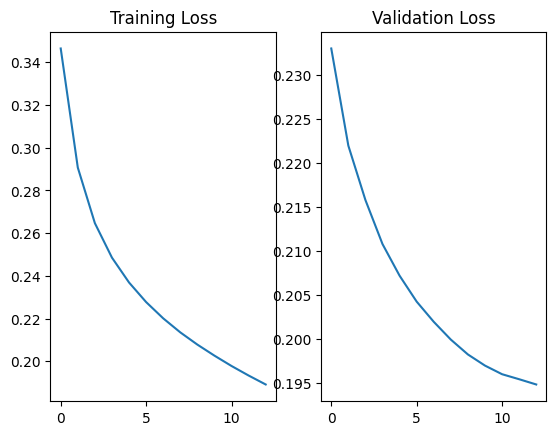

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2,)
axes[0].plot(train_hist)
axes[0].set_title('Training Loss')

axes[1].plot(val_hist)
axes[1].set_title('Validation Loss')

In [22]:
MODEL.save_pretrained("./finqa_finetune_t5.pth")

In [23]:
logging.info("Model saved")

INFO:root:Model saved


Quantisation testing

In [ ]:
# import torch
# import torch.optim as optim
# import torch.quantization as quantization

# # ... (Assuming you have defined train_loader, val_loader, NUM_EPOCHS, DEVICE, and OPTIMIZER)

# # Set the T5 model to evaluation mode
# t5_model.eval()

# # # Quantize only supported layer types, such as Linear layers, on CPU
# # for name, module in t5_model.named_modules():
# #     if isinstance(module, torch.nn.Linear):
# #         quantization.quantize_dynamic(module, dtype=torch.qint8)

# # Move the quantized model to CPU
# quantized_t5_model_cpu = t5_model.cpu()

# # Move the quantized model to GPU for training
# quantized_t5_model_gpu = quantized_t5_model_cpu.to('cuda')

# train_loss = 0
# val_loss = 0
# b = 0
# v = 0
# train_hist = []
# val_hist = []
# num_batches = len(train_loader)
# print_every = num_batches // 10

# for epoch in range(NUM_EPOCHS):
#     quantized_t5_model_gpu.train()  # Ensure the model is in train mode
#     for batch in tqdm(train_loader, desc="Training batches"):
#         input_ids = batch["input_ids"].to(DEVICE)
#         attention_mask = batch["attention_mask"].to(DEVICE)
#         labels = batch["labels"].to(DEVICE)
#         decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)
#         outputs = MODEL(input_ids=input_ids, attention_mask=attention_mask,
#                                          labels=labels, decoder_attention_mask=decoder_attention_mask)
#         OPTIMIZER.zero_grad()
#         outputs.loss.backward()
#         OPTIMIZER.step()
#         train_loss += outputs.loss.item()
#         b += 1
#         if b % (print_every) == 0:
#             print(f"Batch {b+1}/{num_batches} -> Train loss: {train_loss / b:.4f}")
#     train_hist.append(train_loss / b)

#     # Validation
#     quantized_t5_model_gpu.eval()
#     for batch in tqdm(val_loader, desc="Validation batches"):
#         input_ids = batch["input_ids"].to(DEVICE)
#         attention_mask = batch["attention_mask"].to(DEVICE)
#         labels = batch["labels"].to(DEVICE)
#         decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)
#         with torch.no_grad():
#             outputs = quantized_t5_model_gpu(input_ids=input_ids, attention_mask=attention_mask,
#                                              labels=labels, decoder_attention_mask=decoder_attention_mask)
#         val_loss += outputs.loss.item()
#         v += 1
#     val_hist.append(val_loss / v)
#     print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train loss: {train_hist[-1]:.4f}\tValidation loss: {val_hist[-1]:.4f}")
